In [41]:
import os
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder

import cv2
from sklearn.metrics import classification_report
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision


In [42]:
data_dir = "/Users/sharanyu/Desktop/AIproject/flowers"  # Change this to the path of the dataset on your system
classes = os.listdir(data_dir)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")


Number of classes: 16
Classes: ['calendula', 'bellflower', 'iris', 'astilbe', 'common_daisy', 'california_poppy', 'carnation', 'rose', 'tulip', 'black_eyed_susan', 'coreopsis', 'dandelion', 'water_lily', 'magnolia', 'sunflower', 'daffodil']


In [43]:
data_dir = "/Users/sharanyu/Desktop/AIproject/flowers"
class_names = os.listdir(data_dir)
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

In [44]:
device = torch.device('mps')

In [45]:
# analyzing the dataset, determining the no. of classes, dimesnions and files/class.
rows = []
file_count = 0
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_files = len(os.listdir(class_dir))
    total_width = 0
    total_height = 0
    
    for img_name in os.listdir(class_dir):
        try:
          img_path = os.path.join(class_dir, img_name)
          img = cv2.imread(img_path)
          height, width, channels = img.shape
          total_width += width
          total_height += height
          file_count += 1
        except Exception as e:
          print(img_path)
          print(str(e))
    avg_width = total_width // num_files
    avg_height = total_height // num_files
    rows.append({"Class": class_name, "NumFiles": num_files, "AvgWidth": avg_width, "AvgHeight": avg_height})

df = pd.DataFrame(rows)
print(df)
print("Total files: ",file_count)

               Class  NumFiles  AvgWidth  AvgHeight
0          calendula       978       256        256
1         bellflower       873       256        256
2               iris      1054       256        256
3            astilbe       737       256        256
4       common_daisy       980       256        256
5   california_poppy      1022       256        256
6          carnation       923       256        256
7               rose       999       256        256
8              tulip      1048       256        256
9   black_eyed_susan      1000       256        256
10         coreopsis      1047       256        256
11         dandelion      1052       256        256
12        water_lily       982       781        586
13          magnolia      1048       256        256
14         sunflower      1027       256        256
15          daffodil       970       256        256
Total files:  15740


In [46]:
# Hyperparameters
num_epochs = 25
batch_size = 128
learning_rate = 0.0001

In [47]:
# Data augmentation for the train data.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),    
    transforms.RandomRotation(10),        
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),     
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),  
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])


In [48]:
dataset = ImageFolder(root='flowers', transform=train_transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# creating dataloaders with bathc size of 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [49]:
model = torchvision.models.resnet18(pretrained = True) # resnet transfer learning for dataset 3

for param in model.parameters():
    param.requires_grad = False

# Replace the last layer of the fully connected part of the network
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
from tqdm import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}')):
        # Move data to device
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(scores.data, 1)
        total += targets.size(0)
        correct += (predictions == targets).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}'):

            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

            _, predictions = torch.max(scores.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pt')

    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc=f'Test Epoch {epoch+1}/{num_epochs}'):
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)

            _, predictions = torch.max(scores.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Accuracy: {val_accuracy:.2f}%, '
          f'Test Accuracy: {test_accuracy:.2f}%')


Test Epoch 1/25: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Epoch 1/25, Train Loss: 2.7362, Train Accuracy: 11.97%, Val Accuracy: 17.79%, Test Accuracy: 19.73%


Test Epoch 2/25: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Epoch 2/25, Train Loss: 2.4372, Train Accuracy: 27.70%, Val Accuracy: 33.61%, Test Accuracy: 34.56%


Test Epoch 3/25: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Epoch 3/25, Train Loss: 2.2110, Train Accuracy: 39.73%, Val Accuracy: 44.73%, Test Accuracy: 44.54%


Test Epoch 4/25: 100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


Epoch 4/25, Train Loss: 2.0282, Train Accuracy: 48.03%, Val Accuracy: 51.78%, Test Accuracy: 52.35%


Test Epoch 5/25: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Epoch 5/25, Train Loss: 1.8757, Train Accuracy: 54.36%, Val Accuracy: 54.70%, Test Accuracy: 55.59%


Test Epoch 6/25: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Epoch 6/25, Train Loss: 1.7392, Train Accuracy: 57.93%, Val Accuracy: 56.54%, Test Accuracy: 57.43%


Test Epoch 7/25: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch 7/25, Train Loss: 1.6432, Train Accuracy: 60.26%, Val Accuracy: 59.53%, Test Accuracy: 59.72%


Test Epoch 8/25: 100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch 8/25, Train Loss: 1.5622, Train Accuracy: 62.57%, Val Accuracy: 60.48%, Test Accuracy: 60.86%


Test Epoch 9/25: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


Epoch 9/25, Train Loss: 1.4835, Train Accuracy: 63.23%, Val Accuracy: 61.31%, Test Accuracy: 63.44%


Test Epoch 10/25: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Epoch 10/25, Train Loss: 1.4199, Train Accuracy: 64.47%, Val Accuracy: 63.41%, Test Accuracy: 64.55%


Test Epoch 11/25: 100%|██████████| 25/25 [00:19<00:00,  1.31it/s]


Epoch 11/25, Train Loss: 1.3840, Train Accuracy: 64.61%, Val Accuracy: 62.90%, Test Accuracy: 64.68%


Test Epoch 12/25: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Epoch 12/25, Train Loss: 1.3370, Train Accuracy: 65.84%, Val Accuracy: 65.06%, Test Accuracy: 65.47%


Test Epoch 13/25: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s]


Epoch 13/25, Train Loss: 1.2811, Train Accuracy: 67.20%, Val Accuracy: 65.37%, Test Accuracy: 66.26%


Test Epoch 14/25: 100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


Epoch 14/25, Train Loss: 1.2535, Train Accuracy: 67.14%, Val Accuracy: 67.22%, Test Accuracy: 67.34%


Test Epoch 15/25: 100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Epoch 15/25, Train Loss: 1.2239, Train Accuracy: 67.24%, Val Accuracy: 65.37%, Test Accuracy: 65.18%


Test Epoch 16/25: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s]


Epoch 16/25, Train Loss: 1.1947, Train Accuracy: 68.02%, Val Accuracy: 67.92%, Test Accuracy: 67.31%


Test Epoch 17/25: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


Epoch 17/25, Train Loss: 1.1708, Train Accuracy: 68.37%, Val Accuracy: 67.85%, Test Accuracy: 67.31%


Test Epoch 18/25: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch 18/25, Train Loss: 1.1469, Train Accuracy: 68.61%, Val Accuracy: 68.04%, Test Accuracy: 67.53%


Test Epoch 19/25: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


Epoch 19/25, Train Loss: 1.1291, Train Accuracy: 69.44%, Val Accuracy: 67.03%, Test Accuracy: 67.22%


Test Epoch 20/25: 100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


Epoch 20/25, Train Loss: 1.1104, Train Accuracy: 69.66%, Val Accuracy: 67.79%, Test Accuracy: 67.41%


Test Epoch 21/25: 100%|██████████| 25/25 [00:19<00:00,  1.26it/s]


Epoch 21/25, Train Loss: 1.0999, Train Accuracy: 69.61%, Val Accuracy: 69.89%, Test Accuracy: 69.09%


Test Epoch 22/25: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s]


Epoch 22/25, Train Loss: 1.0919, Train Accuracy: 69.70%, Val Accuracy: 66.96%, Test Accuracy: 69.22%


Test Epoch 23/25: 100%|██████████| 25/25 [00:19<00:00,  1.25it/s]


Epoch 23/25, Train Loss: 1.0586, Train Accuracy: 70.68%, Val Accuracy: 68.17%, Test Accuracy: 68.39%


Test Epoch 24/25: 100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


Epoch 24/25, Train Loss: 1.0709, Train Accuracy: 70.21%, Val Accuracy: 69.31%, Test Accuracy: 69.22%


Test Epoch 25/25: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]

Epoch 25/25, Train Loss: 1.0434, Train Accuracy: 70.42%, Val Accuracy: 68.68%, Test Accuracy: 70.78%


In [51]:
#  initial run fullOutput:

'''    Epoch 1/25, Batch 0/79, Loss 2.9198
    Validation accuracy: 19.61%
    Test accuracy: 19.12%
    Epoch 2/25, Batch 0/79, Loss 2.5499
    Validation accuracy: 34.10%
    Test accuracy: 33.04%
    Epoch 3/25, Batch 0/79, Loss 2.3307
    Validation accuracy: 44.54%
    Test accuracy: 44.35%
    Epoch 4/25, Batch 0/79, Loss 2.1449
    Validation accuracy: 51.13%
    Test accuracy: 50.73%
    Epoch 5/25, Batch 0/79, Loss 2.0068
    Validation accuracy: 55.22%
    Test accuracy: 54.67%
    Epoch 6/25, Batch 0/79, Loss 1.8410
    Validation accuracy: 58.67%
    Test accuracy: 58.13%
    Epoch 7/25, Batch 0/79, Loss 1.6271
    Validation accuracy: 60.06%
    Test accuracy: 59.91%
    Epoch 8/25, Batch 0/79, Loss 1.5167
    Validation accuracy: 61.93%
    Test accuracy: 60.99%
    Epoch 9/25, Batch 0/79, Loss 1.5282
    Validation accuracy: 62.76%
    Test accuracy: 62.23%
    Epoch 10/25, Batch 0/79, Loss 1.3853
    Validation accuracy: 63.80%
    Test accuracy: 63.63%
    Epoch 11/25, Batch 0/79, Loss 1.4738
    Validation accuracy: 65.11%
    Test accuracy: 63.95%
    Epoch 12/25, Batch 0/79, Loss 1.3234
    Validation accuracy: 66.14%
    Test accuracy: 65.41%
    Epoch 13/25, Batch 0/79, Loss 1.3975
    Validation accuracy: 66.42%
    Test accuracy: 65.47%
    Epoch 14/25, Batch 0/79, Loss 1.3211
    Validation accuracy: 66.38%
    Test accuracy: 66.26%
    Epoch 15/25, Batch 0/79, Loss 1.2833
    Validation accuracy: 66.61%
    Test accuracy: 66.26%
    Epoch 16/25, Batch 0/79, Loss 1.2273
    Validation accuracy: 67.29%
    Test accuracy: 67.09%
    Epoch 17/25, Batch 0/79, Loss 1.1177
    Validation accuracy: 66.97%
    Test accuracy: 67.34%
    Epoch 18/25, Batch 0/79, Loss 1.0788
    Validation accuracy: 67.69%
    Test accuracy: 68.04%
    Epoch 19/25, Batch 0/79, Loss 1.2609
    Validation accuracy: 67.84%
    Test accuracy: 67.79%
    Epoch 20/25, Batch 0/79, Loss 1.0463
    Validation accuracy: 68.40%
    Test accuracy: 68.30%
    Epoch 21/25, Batch 0/79, Loss 1.0968
    Validation accuracy: 68.44%
    Test accuracy: 68.65%
    Epoch 22/25, Batch 0/79, Loss 1.0011
    Validation accuracy: 68.52%
    Test accuracy: 68.87%
    Epoch 23/25, Batch 0/79, Loss 1.3195
    Validation accuracy: 68.72%
    Test accuracy: 69.12%
    Epoch 24/25, Batch 0/79, Loss 0.9101
    Validation accuracy: 68.80%
    Test accuracy: 69.22%
    Epoch 25/25, Batch 0/79, Loss 0.9813
    Validation accuracy: 69.08%
    Test accuracy: 69.47%
'''

'    Epoch 1/25, Batch 0/79, Loss 2.9198\n    Validation accuracy: 19.61%\n    Test accuracy: 19.12%\n    Epoch 2/25, Batch 0/79, Loss 2.5499\n    Validation accuracy: 34.10%\n    Test accuracy: 33.04%\n    Epoch 3/25, Batch 0/79, Loss 2.3307\n    Validation accuracy: 44.54%\n    Test accuracy: 44.35%\n    Epoch 4/25, Batch 0/79, Loss 2.1449\n    Validation accuracy: 51.13%\n    Test accuracy: 50.73%\n    Epoch 5/25, Batch 0/79, Loss 2.0068\n    Validation accuracy: 55.22%\n    Test accuracy: 54.67%\n    Epoch 6/25, Batch 0/79, Loss 1.8410\n    Validation accuracy: 58.67%\n    Test accuracy: 58.13%\n    Epoch 7/25, Batch 0/79, Loss 1.6271\n    Validation accuracy: 60.06%\n    Test accuracy: 59.91%\n    Epoch 8/25, Batch 0/79, Loss 1.5167\n    Validation accuracy: 61.93%\n    Test accuracy: 60.99%\n    Epoch 9/25, Batch 0/79, Loss 1.5282\n    Validation accuracy: 62.76%\n    Test accuracy: 62.23%\n    Epoch 10/25, Batch 0/79, Loss 1.3853\n    Validation accuracy: 63.80%\n    Test accura

In [52]:
train_losses

[2.7362416941544105,
 2.437153862810683,
 2.2109533068777503,
 2.0281994287995087,
 1.8757019454035266,
 1.739153338574815,
 1.643197174729972,
 1.562198290879699,
 1.48349029716404,
 1.4199479160637691,
 1.3839871307899212,
 1.3370356463837898,
 1.2810864928124965,
 1.2534921950307385,
 1.2239204097068173,
 1.1946876062743965,
 1.170815182828355,
 1.1469230473726646,
 1.1290788006508488,
 1.1104345040759822,
 1.0999445216409092,
 1.091912923873156,
 1.0585887973335968,
 1.0709128544248383,
 1.0433924574961608]

In [53]:
val_losses

[2.5866131599132833,
 2.3129028356992283,
 2.1126818290123572,
 1.9629716414671678,
 1.8411817642358632,
 1.7340213793974657,
 1.6312546730041504,
 1.56573997094081,
 1.4953753581413856,
 1.443655747633714,
 1.4017449525686412,
 1.3400623706670909,
 1.3113977450590868,
 1.245552659034729,
 1.2413435440797072,
 1.2174330766384418,
 1.1951091197820811,
 1.1630707337306097,
 1.1792270220243013,
 1.115990712092473,
 1.0975954899421105,
 1.1442402601242065,
 1.0981418215311491,
 1.0814099311828613,
 1.0823880754984343]

In [54]:
val_accuracies

[17.78907242693774,
 33.60864040660737,
 44.72681067344346,
 51.778907242693776,
 54.70139771283355,
 56.5438373570521,
 59.52986022871664,
 60.48284625158831,
 61.30876747141042,
 63.405336721728084,
 62.89707750952986,
 65.0571791613723,
 65.37484116899618,
 67.21728081321474,
 65.37484116899618,
 67.9161372299873,
 67.85260482846252,
 68.04320203303685,
 67.02668360864041,
 67.78907242693774,
 69.8856416772554,
 66.96315120711563,
 68.1702668360864,
 69.3138500635324,
 68.67852604828462]

In [55]:
train_accuracies

[11.971319658740244,
 27.70012706480305,
 39.725903067707385,
 48.03049555273189,
 54.35650753312761,
 57.932474133236525,
 60.25594481757125,
 62.57033944454529,
 63.23289163187511,
 64.46723543292794,
 64.61245235069886,
 65.837720094391,
 67.19912869849337,
 67.14467235432927,
 67.2354329279361,
 68.0159738609548,
 68.36994009802142,
 68.61499364675984,
 69.44091486658196,
 69.65874024323834,
 69.61335995643492,
 69.70412053004175,
 70.68433472499547,
 70.21237974223997,
 70.42112906153567]

In [56]:
test_accuracies

[19.726810673443456,
 34.561626429479034,
 44.53621346886912,
 52.35069885641677,
 55.590851334180435,
 57.433290978398986,
 59.72045743329098,
 60.864040660736975,
 63.43710292249047,
 64.54891994917408,
 64.67598475222363,
 65.47013977128336,
 66.26429479034307,
 67.34434561626429,
 65.18424396442185,
 67.3125794155019,
 67.3125794155019,
 67.53494282083862,
 67.21728081321474,
 67.40787801778907,
 69.09148665819568,
 69.21855146124524,
 68.39263024142312,
 69.21855146124524,
 70.77509529860228]

Test set evaluation: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]

AUC: 0.28


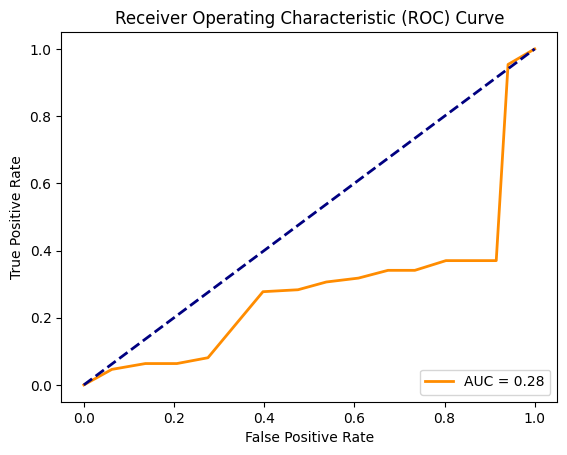

[[112   3   0   2   3   4   5   1   0   6   0   5   0   0   2   1]
 [  8 101   0   0   5   0   4   2   4   1  16  18   3   0   3   8]
 [  2   0 155   5   6   0   2  16   1   0   0   0   0  12   2   0]
 [  1   1  12  85  25  11   3  33   6   6   0   3   2  14  10   0]
 [ 15   6   2   7  98   3   4  10  12   5   3   3   5   0   9   1]
 [  3   4   3   3   7 107   2   1   6   5   0  12  19   1   5   6]
 [  9   9   2   3   1   3 161   1   3   5   3   2   0   2   5   5]
 [  5   3   8  15  15   2   0 134   6   2   0   0   0   8   2   1]
 [  0   4   0   1  11   1   4   7 130   2   3   1   4   3   9   0]
 [  2   2   0  13   3   2   4   1   2 190   0   1   0   4   0   2]
 [  0  25   0   0   2   7   1   0   4   0 149   9   8   0   3   0]
 [ 18   9   0   0   3   9   5   0   3   5   6 138   7   0  12   7]
 [  1   3   0   2   7  23   1   1   1   1   4  10 144   0  15   4]
 [  0   2   4   8   8   0   0   7   8   2   1   1   1 164   1   3]
 [  5   1   0   0  12   3   0   0   2   1   0   3  11   0 140 

In [57]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc=f'Test set evaluation'):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)

        probabilities = nn.functional.softmax(scores, dim=1)

        _, predictions = torch.max(probabilities, 1)

        true_labels += targets.tolist()
        predicted_labels += predictions.tolist()

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)


In [58]:
epochslist = []
for i in range(num_epochs):
    epochslist.append(i+1)


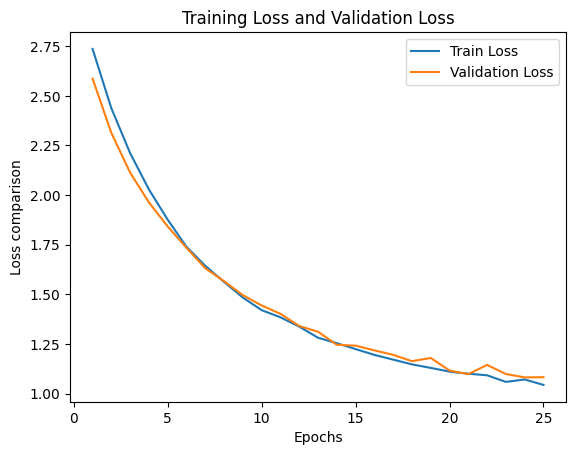

In [59]:
import matplotlib.pyplot as plt

plt.plot(epochslist, train_losses, label='Train Loss')
plt.plot(epochslist, val_losses, label='Validation Loss')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss comparison')

plt.legend()

plt.show()


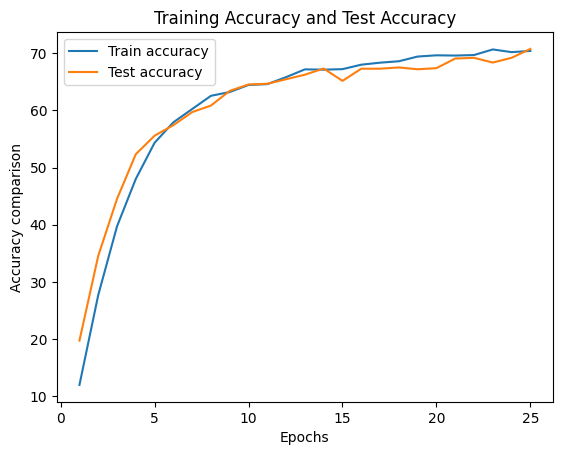

In [60]:
import matplotlib.pyplot as plt

plt.plot(epochslist, train_accuracies, label='Train accuracy')
plt.plot(epochslist, test_accuracies, label='Test accuracy')
plt.title('Training Accuracy and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy comparison')

plt.legend()
plt.show()

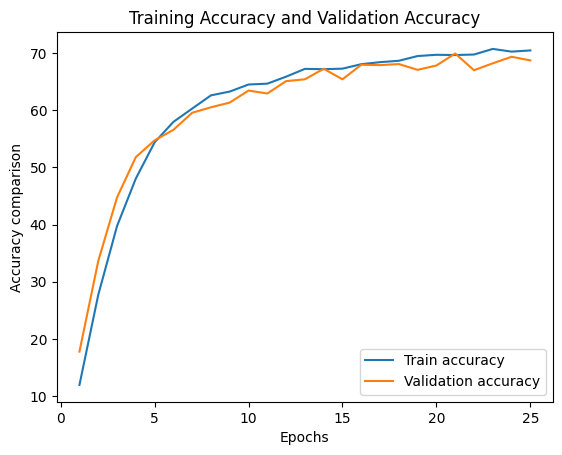

In [61]:
import matplotlib.pyplot as plt

plt.plot(epochslist, train_accuracies, label='Train accuracy')
plt.plot(epochslist, val_accuracies, label='Validation accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy comparison')

plt.legend()
plt.show()

In [62]:
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[112   3   0   2   3   4   5   1   0   6   0   5   0   0   2   1]
 [  8 101   0   0   5   0   4   2   4   1  16  18   3   0   3   8]
 [  2   0 155   5   6   0   2  16   1   0   0   0   0  12   2   0]
 [  1   1  12  85  25  11   3  33   6   6   0   3   2  14  10   0]
 [ 15   6   2   7  98   3   4  10  12   5   3   3   5   0   9   1]
 [  3   4   3   3   7 107   2   1   6   5   0  12  19   1   5   6]
 [  9   9   2   3   1   3 161   1   3   5   3   2   0   2   5   5]
 [  5   3   8  15  15   2   0 134   6   2   0   0   0   8   2   1]
 [  0   4   0   1  11   1   4   7 130   2   3   1   4   3   9   0]
 [  2   2   0  13   3   2   4   1   2 190   0   1   0   4   0   2]
 [  0  25   0   0   2   7   1   0   4   0 149   9   8   0   3   0]
 [ 18   9   0   0   3   9   5   0   3   5   6 138   7   0  12   7]
 [  1   3   0   2   7  23   1   1   1   1   4  10 144   0  15   4]
 [  0   2   4   8   8   0   0   7   8   2   1   1   1 164   1   3]
 [  5   1   0   0  12   3   0   0   2   1   0   3  11   0 140 

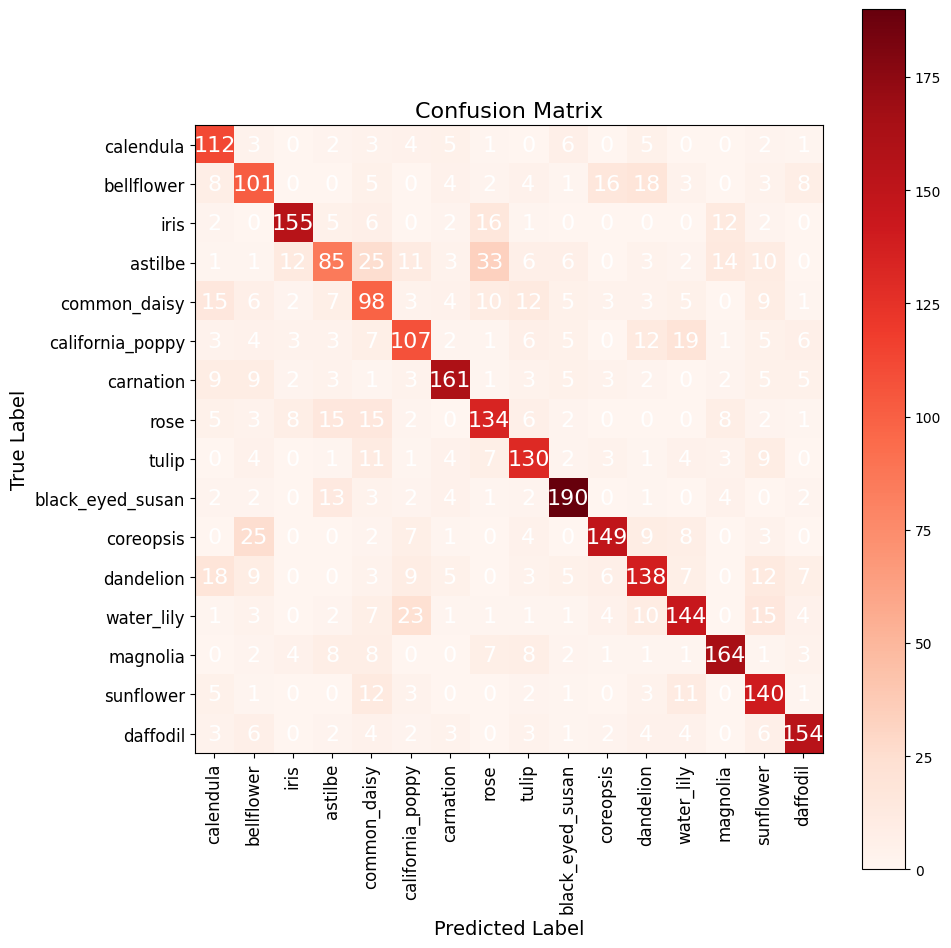

In [69]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Reds)
plt.title('Confusion Matrix', fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, fontsize=12)
plt.yticks(tick_marks, class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

plt.tight_layout()
plt.show()